<a href="https://colab.research.google.com/github/ko74dev/studstat/blob/main/studstat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Загрузим нужные библиотеки

In [1]:
!pip install -U sentence_transformers
!pip install -U catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.6 MB/s 
     |████████████████████████████████| 4.9 MB 41.3 MB/s 
     |████████████████████████████████| 1.3 MB 48.5 MB/s 
     |████████████████████████████████| 120 kB 25.8 MB/s 
     |████████████████████████████████| 6.6 MB 55.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125938 sha256=bdf97712e59174137997714223a39d35f504649d39bd937c3fcafa7582493397
  Stored in directory: /root/.cache/pip/wheels/bf/06/fb/d59c1e5bd1dac7f6cf61ec0036cc3a10ab8fecaa6b2c3d3ee9
Successfully built sentence-transformers
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.2 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score
import numpy as np
from imblearn.over_sampling import ADASYN
from catboost import CatBoostClassifier

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

## Рассмотрим датасет по ближе

In [4]:
df = pd.read_csv("/content/drive/MyDrive/train_dataset_train.csv")
df.shape

(13584, 24)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13584 entries, 0 to 13583
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                13584 non-null  int64  
 1   Код_группы        13584 non-null  int64  
 2   Год_Поступления   13584 non-null  int64  
 3   Пол               13577 non-null  object 
 4   Основания         13584 non-null  object 
 5   Изучаемый_Язык    12758 non-null  object 
 6   Дата_Рождения     13584 non-null  object 
 7   Уч_Заведение      12351 non-null  object 
 8   Где_Находится_УЗ  12203 non-null  object 
 9   Год_Окончания_УЗ  12284 non-null  float64
 10  Пособие           12576 non-null  float64
 11  Страна_ПП         13237 non-null  object 
 12  Регион_ПП         12966 non-null  object 
 13  Город_ПП          13141 non-null  object 
 14  Общежитие         13498 non-null  float64
 15  Наличие_Матери    13584 non-null  int64  
 16  Наличие_Отца      13584 non-null  float6

In [6]:
df.corr()

,ID,Код_группы,Год_Поступления,Год_Окончания_УЗ,Пособие,Общежитие,Наличие_Матери,Наличие_Отца,Опекунство,Село,Иностранец,КодФакультета,СрБаллАттестата,Статус
ID,1.000000,0.764826,0.695542,0.403148,NaN,0.059165,0.227340,0.233302,0.011990,-0.015480,0.112968,0.063387,0.014171,-0.265286
Код_группы,0.764826,1.000000,0.579809,0.393579,NaN,0.087827,0.246644,0.249594,0.006243,-0.031974,0.084208,-0.002302,-0.002305,-0.184447
Год_Поступления,0.695542,0.579809,1.000000,0.444285,NaN,0.068872,0.193887,0.197208,0.014914,-0.016431,0.086738,0.036665,0.004741,-0.234061
Год_Окончания_УЗ,0.403148,0.393579,0.444285,1.000000,NaN,0.158369,0.188252,0.189574,0.010188,0.021259,0.056972,-0.017714,0.016083,-0.101810
Пособие,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Общежитие,0.059165,0.087827,0.068872,0.158369,NaN,1.000000,-0.063634,-0.064805,0.005776,0.187191,0.320743,0.026264,-0.010216,-0.036606
Наличие_Матери,0.227340,0.246644,0.193887,0.188252,NaN,-0.063634,1.000000,0.995588,-0.021510,-0.100948,0.020458,0.043190,0.033259,-0.028311
Наличие_Отца,0.233302,0.249594,0.197208,0.189574,NaN,-0.064805,0.995588,1.000000,-0.021427,-0.102011,0.020947,0.042421,0.033458,-0.029946
Опекунство,0.011990,0.006243,0.014914,0.010188,NaN,0.005776,-0.021510,-0.021427,1.000000,-0.003148,-0.005861,0.002484,-0.001539,-0.031248
Село,-0.015480,-0.031974,-0.016431,0.021259,NaN,0.187191,-0.100948,-0.102011,-0.003148,1.000000,-0.084514,0.028853,-0.003484,0.015433


## Предобработка в данных

In [7]:
def pre(X):
    X['ID'] %= X.Код_группы
    
    for c in ['Общежитие', 'Село', 'Иностранец']:
        X[c] = X[c].map({0:-1, 1:1}).fillna(0).astype(np.int8)
    X['Пол'] = X.Пол.map({'Муж':-1, 'Жен':1}).fillna(0).astype(np.int8)
    
    X['Дата_Рождения'] = pd.to_datetime(X.Дата_Рождения).dt.year.astype(np.uint16)
    X.Год_Окончания_УЗ.fillna(X.Дата_Рождения + 19, inplace=True)
    X['Год_Поступления'] = (X.Год_Поступления - X.Год_Окончания_УЗ).clip(0, 30) / 30
    X['Год_Окончания_УЗ'] = (X.Год_Окончания_УЗ - X.Дата_Рождения).clip(0, 55) / 55
    X.drop(columns=['Дата_Рождения'], inplace=True)
    
    X['Наличие'] = (X.Наличие_Матери+X.Наличие_Отца).astype(np.uint8)
    X.drop(columns=['Наличие_Матери','Наличие_Отца'], inplace=True)

    X.loc[X.СрБаллАттестата == 0, 'СрБаллАттестата'] = 33
    for cntri in [((X.СрБаллАттестата>0) & (X.СрБаллАттестата<6)),
                 ((X.СрБаллАттестата>=8) & (X.СрБаллАттестата<21)),
                 ((X.СрБаллАттестата>20) & (X.СрБаллАттестата<30)),
                 ((X.СрБаллАттестата>=30) & (X.СрБаллАттестата<=100)),
                 ((X.СрБаллАттестата>1000))]:
        if not cntri.size: continue
        mi = X.loc[cntri,'СрБаллАттестата'].min()
        ma = X.loc[cntri,'СрБаллАттестата'].max()
        if mi == ma: mi,ma = 0,ma/2
        X.loc[cntri, 'СрБаллАттестата'] = X.loc[cntri, 
                                     'СрБаллАттестата'].map(lambda x: (x - mi) / ma)
    X.СрБаллАттестата.clip(0,1, inplace=True)    
    X = pd.get_dummies(X, prefix='Осн', columns=['Основания'])
    X['КодФакультета'] = X.КодФакультета.astype(np.uint8)
    X = pd.get_dummies(X, prefix='CF', columns=['КодФакультета'])
    X['Код_группы'] = (X.Код_группы - X.Код_группы.min())/X.Код_группы.max()

    return X

X = pre(df.drop(columns = ['Где_Находится_УЗ', 'Регион_ПП', 'Город_ПП', 'Страна_ПП',
                           'Страна_Родители', 'Уч_Заведение', 'Изучаемый_Язык']))

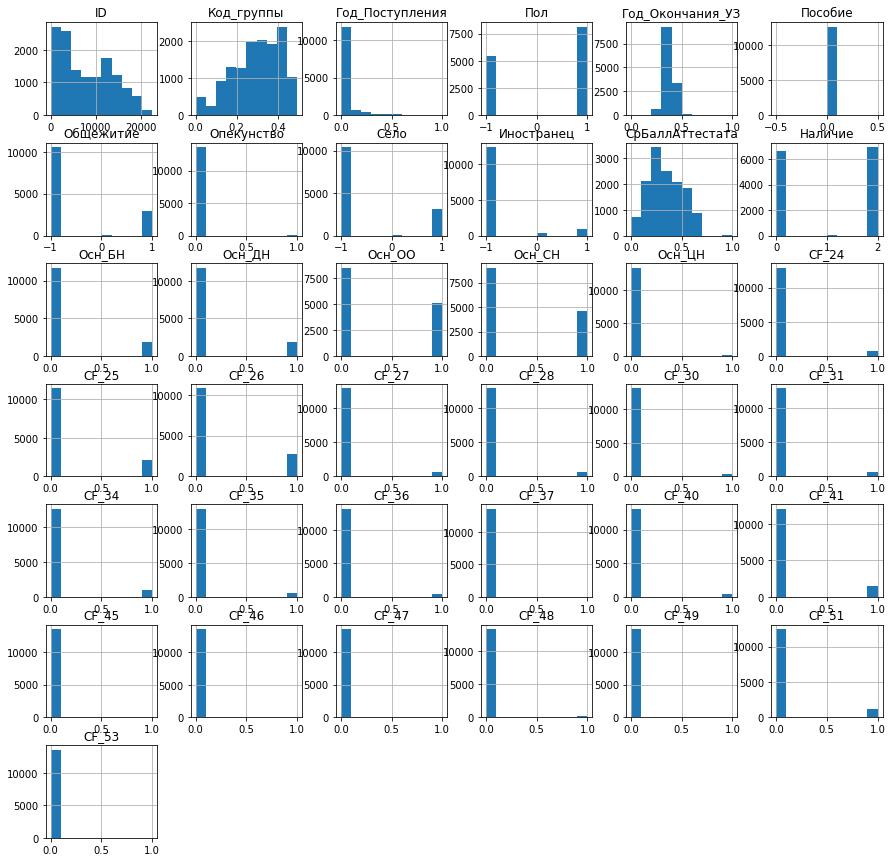

In [8]:
y = X.Статус
X.drop(columns=['Статус'], inplace=True)
_ = X.hist(figsize=(15,15))

In [9]:
X.drop(columns=['Пособие', 'Опекунство',
                'CF_37', 'CF_46', 'CF_47', 'CF_49', 'CF_53',
               ], 
       inplace=True)

In [10]:
X['text'] = df[['Страна_ПП', 'Где_Находится_УЗ', 'Уч_Заведение', 'Изучаемый_Язык',
               'Страна_Родители']].fillna('X'
                        ).apply( lambda x: ' '.join(map(str, x)), axis=1)

In [11]:
model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')
textv = model.encode(X['text'], batch_size =128, show_progress_bar=True,
                     convert_to_numpy=True, device='cuda', normalize_embeddings=True)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Batches:   0%|          | 0/107 [00:00<?, ?it/s]

In [13]:
pca = PCA(n_components=12, svd_solver='full', random_state=42)
pca.fit(pd.DataFrame(textv.tolist()))
pca_train = pca.transform(pd.DataFrame(textv.tolist()))
X = pd.concat([X, pd.DataFrame(pca_train)], axis=1)
X.drop(columns=['text'], inplace=True)

In [14]:
y.value_counts()

 4    8249
 3    4721
-1     614
Name: Статус, dtype: int64

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X, y, test_size=0.15, random_state=0)

In [16]:
y_train.value_counts()

 4    6990
 3    4027
-1     529
Name: Статус, dtype: int64

In [17]:
ada = ADASYN( 
            sampling_strategy='all', random_state=0,
            n_neighbors=7, n_jobs=-1)

X_b, y_b = ada.fit_resample(X_train, y_train)
y_b.value_counts()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


-1    7047
 4    6990
 3    6775
Name: Статус, dtype: int64

In [18]:
cbc = CatBoostClassifier(random_state=42, iterations=2000, task_type='GPU',
                          learning_rate = 0.033, depth=9, l2_leaf_reg=4,
                            early_stopping_rounds = 50)
cbc.fit(X_b, y_b, 
        eval_set = (X_test, y_test),verbose=100)
f1_score(y_test, cbc.predict(X_test), average='macro', zero_division = 0)

0:	learn: 1.0663216	test: 1.0700699	best: 1.0700699 (0)	total: 33.1ms	remaining: 1m 6s
100:	learn: 0.4263519	test: 0.4772321	best: 0.4772321 (100)	total: 1.82s	remaining: 34.1s
200:	learn: 0.3463890	test: 0.4142549	best: 0.4142549 (200)	total: 3.48s	remaining: 31.1s
300:	learn: 0.3003811	test: 0.3890609	best: 0.3890609 (300)	total: 5.16s	remaining: 29.1s
400:	learn: 0.2660545	test: 0.3738119	best: 0.3738119 (400)	total: 6.83s	remaining: 27.2s
500:	learn: 0.2400570	test: 0.3620517	best: 0.3620517 (500)	total: 8.48s	remaining: 25.4s
600:	learn: 0.2188641	test: 0.3556740	best: 0.3556740 (600)	total: 10.2s	remaining: 23.8s
700:	learn: 0.2010730	test: 0.3501828	best: 0.3501828 (700)	total: 11.9s	remaining: 22s
800:	learn: 0.1861352	test: 0.3467176	best: 0.3467176 (800)	total: 13.6s	remaining: 20.4s
900:	learn: 0.1734425	test: 0.3448709	best: 0.3446956 (897)	total: 15.3s	remaining: 18.7s
1000:	learn: 0.1616837	test: 0.3431490	best: 0.3431490 (1000)	total: 16.9s	remaining: 16.9s
1100:	learn: 

0.773309974996776

# Cоздание файла с ответом

In [19]:
df_test = pd.read_csv("/content/drive/MyDrive/test_dataset_test.csv")
df_submission = pd.read_csv("/content/drive/MyDrive/sample_submission.csv")

Провем те же манипуляции с данными что и на обучении

In [20]:
text = df_test[['Страна_ПП', 'Где_Находится_УЗ', 'Уч_Заведение', 
                      'Изучаемый_Язык', 'Страна_Родители']].fillna('X'
                        ).apply( lambda x: ' '.join(map(str, x)), axis=1
                               )

In [21]:
df_test = pre(df_test.drop(columns = [
                       'Где_Находится_УЗ', 'Регион_ПП', 'Город_ПП', 'Страна_ПП',
                           'Страна_Родители', 'Уч_Заведение', 'Изучаемый_Язык',
                      ]))

In [22]:
df_test.drop(columns=['Пособие', 'Опекунство',
                'CF_37', 'CF_46', 'CF_53', 'CF_47', 'CF_49',
               ], 
             inplace=True)

In [23]:
textv =  model.encode(text, batch_size =128, show_progress_bar=True,
                     convert_to_numpy=True, device='cuda', normalize_embeddings=True)
pca_test = pca.transform(pd.DataFrame(textv.tolist()))

Batches:   0%|          | 0/53 [00:00<?, ?it/s]

In [24]:
df_test = pd.concat([df_test, pd.DataFrame(pca_test)], axis=1)

In [25]:
df_submission["Статус"] = cbc.predict(df_test)
df_submission.head(4)

,ID,Статус
0,64996,4
1,71837,4
2,86587,-1
3,73673,-1


In [26]:
df_submission.to_csv("sub.csv", index=False)